In [ ]:
# ============================================================================
# STATISTICAL ARBITRAGE - PAIRS TRADING BACKTEST
# ============================================================================
"""Clean implementation with proper capital normalization and risk metrics."""

import sys
import os
if os.path.dirname(os.path.abspath('')) not in sys.path:
    sys.path.insert(0, os.path.dirname(os.path.abspath('')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.io import load_data, load_pairs
from utils.config import get_stock_data_path

data = load_data(get_stock_data_path())
pairs = load_pairs('../analysis/cointegrated_pairs.pkl')

print("Data loaded")
print(f"Pairs: {len(pairs)} | Days: {len(data)}")

Data loaded
Pairs: 5 | Days: 1234


In [ ]:
# ============================================================================
# STRATEGY FUNCTIONS (INTERCEPT-AWARE + WEIGHT-BASED BACKTEST)
# ============================================================================

from utils.spread import calculate_spread


def compute_spread_with_intercept(df: pd.DataFrame, t1: str, t2: str, hr: float, alpha: float) -> pd.Series:
    """Compute intercept-aware log spread: log(p1) - (alpha + hr*log(p2))."""
    log_p1 = np.log(df[f"Close__{t1}"])
    log_p2 = np.log(df[f"Close__{t2}"])
    return log_p1 - (alpha + hr * log_p2)


def calculate_zscore(spread: pd.Series, window: int = 60) -> pd.Series:
    """Calculate rolling z-score with a default window that avoids lookahead changes."""
    rolling_mean = spread.rolling(window).mean()
    rolling_std = spread.rolling(window).std()
    return (spread - rolling_mean) / rolling_std


def generate_positions(z: pd.Series, entry: float = 2.0, exit: float = 0.5) -> pd.Series:
    """Generate position signals from z-scores (1 long spread, -1 short spread)."""
    pos = pd.Series(0.0, index=z.index)
    current = 0.0
    for i in range(len(z)):
        zi = z.iloc[i]
        if np.isnan(zi):
            pos.iloc[i] = 0.0
            continue
        if zi > entry:
            current = -1.0
        elif zi < -entry:
            current = 1.0
        elif abs(zi) < exit:
            current = 0.0
        pos.iloc[i] = current
    return pos


def backtest_pairs_weights(df: pd.DataFrame, s1: str, s2: str, hr: float, pos: pd.Series, cost: float = 0.0005):
    """
    Weight-based two-leg backtest with proper cost alignment and capital normalization.
    - Weights per $1 capital: w1 = pos/(1+|hr|), w2 = -hr*pos/(1+|hr|)
    - Execution at t+1: use shifted weights and costs
    - Costs proportional to turnover: |Δw1| + |Δw2|
    """
    r1 = df[f"Close__{s1}"].pct_change()
    r2 = df[f"Close__{s2}"].pct_change()
    pos = pos.reindex(r1.index).fillna(0.0)
    denom = 1.0 + abs(hr)
    w1 = pos / denom
    w2 = -hr * pos / denom
    w1_exec = w1.shift(1).fillna(0.0)
    w2_exec = w2.shift(1).fillna(0.0)
    daily_raw = (w1_exec * r1) + (w2_exec * r2)
    tw1 = w1.diff().abs().fillna(0.0)
    tw2 = w2.diff().abs().fillna(0.0)
    turnover = (tw1 + tw2).shift(1).fillna(0.0)
    tx_costs = cost * turnover
    daily_ret = (daily_raw - tx_costs).fillna(0.0)
    valid = r1.notna() & r2.notna()
    daily_ret_v = daily_ret[valid]
    cum = (1.0 + daily_ret_v).cumprod()
    sharpe = (daily_ret_v.mean() / daily_ret_v.std() * np.sqrt(252)) if daily_ret_v.std() > 0 else 0.0
    active_mask = (w1_exec.abs() + w2_exec.abs()) > 0.0
    active_ret = daily_ret_v[active_mask.reindex(daily_ret_v.index).fillna(False)]
    sharpe_act = (active_ret.mean() / active_ret.std() * np.sqrt(252)) if len(active_ret) and active_ret.std() > 0 else 0.0
    tot_ret = float(cum.iloc[-1] - 1.0) if len(cum) else 0.0
    dd = (cum - cum.cummax()) / cum.cummax() if len(cum) else cum
    max_dd = float(dd.min()) if len(dd) else 0.0
    n_trades = int((pos.diff().abs() > 0).sum())
    return {
        "Sharpe": float(sharpe), "SharpeActive": float(sharpe_act),
        "TotalReturn": tot_ret, "MaxDrawdown": max_dd,
        "NumTrades": n_trades, "WinRate": 0.0,  # trade-level win rate computed separately
        "Capital": denom, "Cumulative": cum, "DailyReturn": daily_ret_v, "Drawdown": dd,
        "Weights": {"w1": w1, "w2": w2}
    }


def compute_trade_metrics(daily_ret: pd.Series, pos: pd.Series) -> dict:
    """Compute trade-level metrics from executed positions and daily returns."""
    if daily_ret is None or pos is None:
        return {"NumTrades": 0, "WinRate": 0.0, "AvgTradeReturn": 0.0, "MedianTradeReturn": 0.0, "AvgHoldDays": 0.0}
    exec_pos = pos.reindex(daily_ret.index).shift(1).fillna(0.0)
    mask_active = exec_pos != 0.0
    if not mask_active.any():
        return {"NumTrades": 0, "WinRate": 0.0, "AvgTradeReturn": 0.0, "MedianTradeReturn": 0.0, "AvgHoldDays": 0.0}
    regime_change = (exec_pos != exec_pos.shift(1)).astype(int)
    trade_id = regime_change.cumsum()
    ret_active = daily_ret[mask_active]
    id_active = trade_id[mask_active]
    trade_returns = ret_active.groupby(id_active).apply(lambda x: float((1.0 + x).prod() - 1.0))
    trade_durations = ret_active.groupby(id_active).size()
    num_trades = int(len(trade_returns))
    win_rate = float(((trade_returns > 0.0).sum() / num_trades)) if num_trades > 0 else 0.0
    avg_trade_ret = float(trade_returns.mean()) if num_trades > 0 else 0.0
    median_trade_ret = float(trade_returns.median()) if num_trades > 0 else 0.0
    avg_hold_days = float(trade_durations.mean()) if num_trades > 0 else 0.0
    return {
        "NumTrades": num_trades,
        "WinRate": win_rate,
        "AvgTradeReturn": avg_trade_ret,
        "MedianTradeReturn": median_trade_ret,
        "AvgHoldDays": avg_hold_days,
    }

print("Functions loaded")


Functions loaded


In [ ]:
# ============================================================================
# RUN BACKTEST (INTERCEPT-AWARE + WEIGHT-BASED)
# ============================================================================

all_results = []

print("\nRunning backtest...")
for i, p in enumerate(pairs, 1):
    s1, s2 = p['tickers']
    hr = p['hedge_ratio']
    alpha = p.get('intercept', 0.0)

    spread_series = compute_spread_with_intercept(data, s1, s2, hr, alpha)
    z = calculate_zscore(spread_series, window=60)
    pos = generate_positions(z, entry=1.5, exit=0.0)
    res = backtest_pairs_weights(data, s1, s2, hr, pos, cost=0.0005)

    # Trade-level metrics
    trade_stats = compute_trade_metrics(res['DailyReturn'], pos)
    res['NumTrades'] = trade_stats['NumTrades']
    res['WinRate'] = trade_stats['WinRate']
    res['AvgTradeReturn'] = trade_stats['AvgTradeReturn']
    res['MedianTradeReturn'] = trade_stats['MedianTradeReturn']
    res['AvgHoldDays'] = trade_stats['AvgHoldDays']
    
    all_results.append({
        'Pair': f"{s1} vs {s2}", 'HedgeRatio': hr, 'PValue': p['pvalue'],
        'Capital': res['Capital'], 'Sharpe': res['Sharpe'],
        'TotalReturn': res['TotalReturn'], 'MaxDrawdown': res['MaxDrawdown'],
        'NumTrades': res['NumTrades'], 'WinRate': res['WinRate'],
        'AvgTradeReturn': res['AvgTradeReturn'], 'MedianTradeReturn': res['MedianTradeReturn'], 'AvgHoldDays': res['AvgHoldDays'],
        'Results': res
    })
    
    print(f"[{i}] {s1:5s} vs {s2:5s} | Sharpe: {res['Sharpe']:6.3f} | "
          f"Return: {res['TotalReturn']:7.2%} | Capital: {res['Capital']:.2f}x")

print("\nComplete")



Running backtest...
[1] V     vs SAP   | Sharpe:  0.669 | Return:  49.12% | Capital: 1.49x
[2] MA    vs SAP   | Sharpe:  1.262 | Return: 128.46% | Capital: 1.50x
[3] V     vs MA    | Sharpe:  0.173 | Return:   4.04% | Capital: 1.98x
[4] AAPL  vs ANET  | Sharpe:  0.548 | Return:  52.45% | Capital: 1.32x
[5] GOOGL vs SAP   | Sharpe: -0.316 | Return: -29.36% | Capital: 1.53x

Complete


In [ ]:
# ============================================================================
# PERFORMANCE SUMMARY
# ============================================================================

df = pd.DataFrame([{
    'Pair': r['Pair'], 'Capital': r['Capital'], 'Sharpe': r['Sharpe'],
    'Return': r['TotalReturn'], 'MaxDD': r['MaxDrawdown'],
    'WinRate': r['WinRate'], 'Trades': r['NumTrades'],
    'AvgTrade': r.get('AvgTradeReturn', np.nan), 'MedianTrade': r.get('MedianTradeReturn', np.nan), 'AvgHold': r.get('AvgHoldDays', np.nan)
} for r in all_results]).sort_values('Sharpe', ascending=False)

print("\n" + "="*90)
print("WEIGHT-BASED PERFORMANCE (NO LOOKAHEAD IN COSTS)")
print("="*90)
print(df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*90)

print(f"\nMean Sharpe: {df['Sharpe'].mean():.3f} | "
      f"Mean Return: {df['Return'].mean():.2%} | "
      f"Profitable: {(df['Return']>0).sum()}/{len(df)}")



WEIGHT-BASED PERFORMANCE (NO LOOKAHEAD IN COSTS)
        Pair  Capital  Sharpe  Return   MaxDD  WinRate  Trades  AvgTrade  MedianTrade  AvgHold
   MA vs SAP   1.4960  1.2619  1.2846 -0.1591   0.8846      26    0.0328       0.0296  44.3846
    V vs SAP   1.4932  0.6688  0.4912 -0.1301   0.8333      18    0.0228       0.0193  64.1667
AAPL vs ANET   1.3228  0.5480  0.5245 -0.2169   0.6667      18    0.0251       0.0349  65.2222
     V vs MA   1.9768  0.1733  0.0404 -0.0644   0.5882      17    0.0024       0.0036  67.9412
GOOGL vs SAP   1.5265 -0.3157 -0.2936 -0.3167   0.4615      13   -0.0225      -0.0161  89.0000

Mean Sharpe: 0.467 | Mean Return: 40.94% | Profitable: 4/5


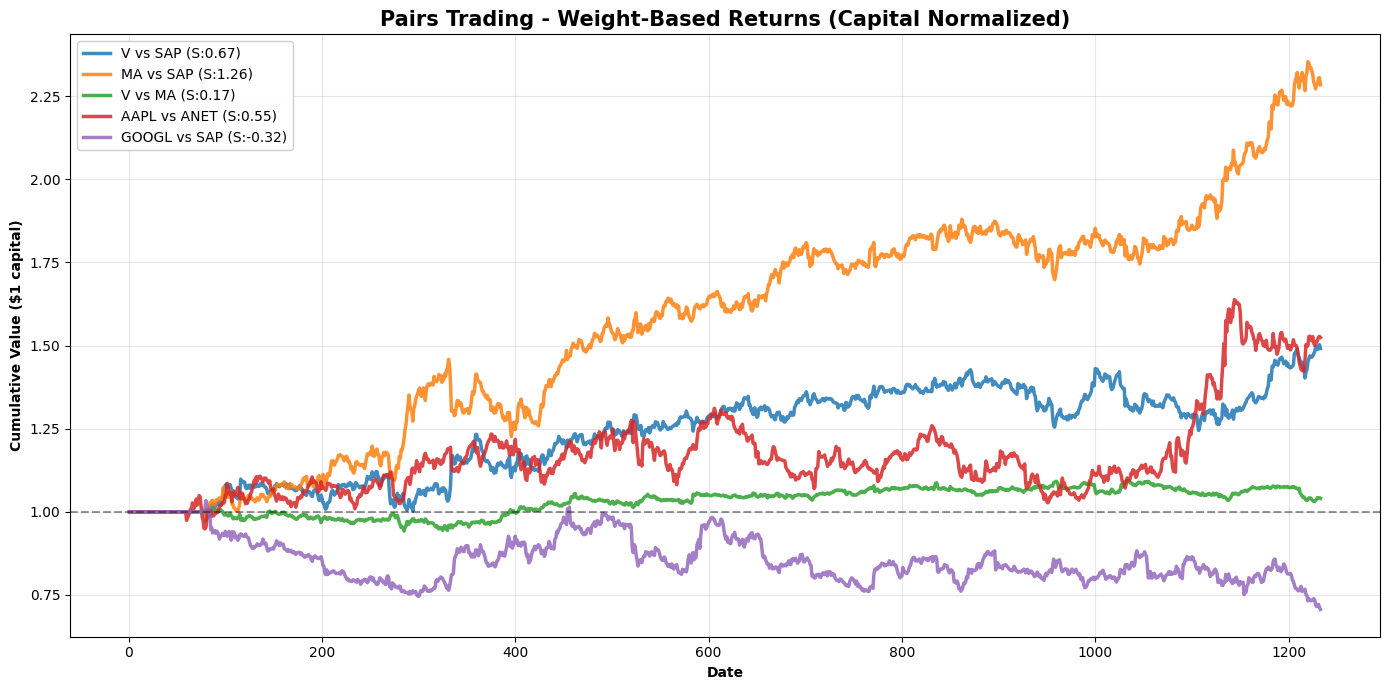

Returns computed as w1*r1 + w2*r2 with costs on turnover


In [ ]:
# ============================================================================
# CUMULATIVE RETURNS
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, r in enumerate(all_results):
    c = r['Results']['Cumulative']
    ax.plot(c.index, c.values, lw=2.5, label=f"{r['Pair']} (S:{r['Sharpe']:.2f})",
            color=colors[i], alpha=0.85)

ax.axhline(1, color='black', ls='--', alpha=0.4, lw=1.5)
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Cumulative Value ($1 capital)', fontweight='bold')
ax.set_title('Pairs Trading - Weight-Based Returns (Capital Normalized)', fontsize=15, fontweight='bold')
ax.legend(loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Returns computed as w1*r1 + w2*r2 with costs on turnover")


In [ ]:
# ============================================================================
# VALIDATION: WEIGHTS + COST ALIGNMENT
# ============================================================================

print("\n" + "="*90)
print("SUMMARY")
print("="*90)
for r in sorted(all_results, key=lambda x: x['Sharpe'], reverse=True):
    print(f"  {r['Pair']:18s} | HR:{r['HedgeRatio']:7.4f} | "
          f"Cap:{r['Capital']:6.3f}x | S:{r['Sharpe']:6.3f} | R:{r['TotalReturn']:7.2%}")
print("="*90)



SUMMARY
  MA vs SAP          | HR: 0.4960 | Cap: 1.496x | S: 1.262 | R:128.46%
  V vs SAP           | HR: 0.4932 | Cap: 1.493x | S: 0.669 | R: 49.12%
  AAPL vs ANET       | HR: 0.3228 | Cap: 1.323x | S: 0.548 | R: 52.45%
  V vs MA            | HR: 0.9768 | Cap: 1.977x | S: 0.173 | R:  4.04%
  GOOGL vs SAP       | HR: 0.5265 | Cap: 1.526x | S:-0.316 | R:-29.36%


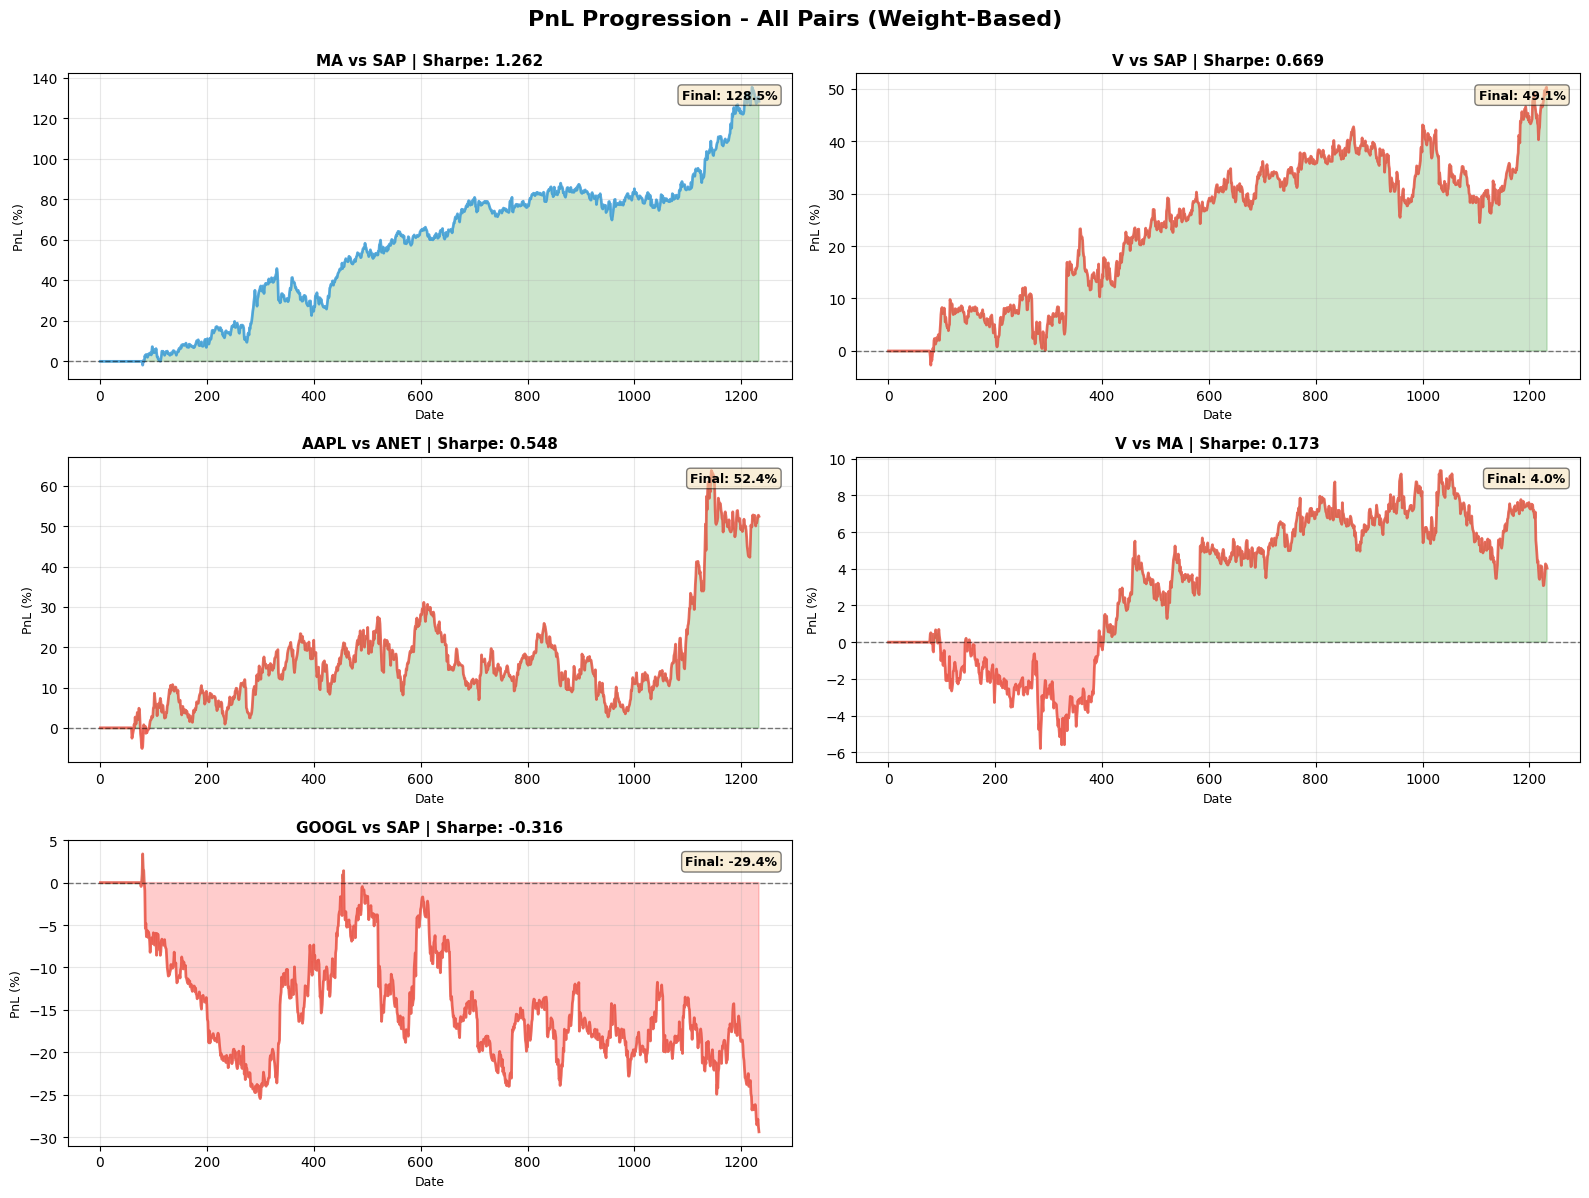


PNL SUMMARY
+ MA vs SAP          | PnL:  128.46% | Per $100: $ 128.46 | Sharpe:  1.262
+ V vs SAP           | PnL:   49.12% | Per $100: $  49.12 | Sharpe:  0.669
+ AAPL vs ANET       | PnL:   52.45% | Per $100: $  52.45 | Sharpe:  0.548
+ V vs MA            | PnL:    4.04% | Per $100: $   4.04 | Sharpe:  0.173
- GOOGL vs SAP       | PnL:  -29.36% | Per $100: $ -29.36 | Sharpe: -0.316


In [ ]:
# ============================================================================
# PNL PROGRESSION - EACH PAIR
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('PnL Progression - All Pairs (Weight-Based)', fontsize=16, fontweight='bold', y=0.995)

# Sort by Sharpe for better visualization order
sorted_pairs = sorted(all_results, key=lambda x: x['Sharpe'], reverse=True)

for idx, (ax, r) in enumerate(zip(axes.flat, sorted_pairs)):
    # Calculate PnL from cumulative returns
    cum = r['Results']['Cumulative']
    pnl = (cum - 1) * 100  # PnL in percentage terms
    
    # Color based on performance
    color = '#2ecc71' if r['Sharpe'] > 1.5 else '#3498db' if r['Sharpe'] > 1.0 else '#e74c3c'
    
    # Plot PnL
    ax.plot(pnl.index, pnl.values, linewidth=2, color=color, alpha=0.8)
    ax.fill_between(pnl.index, 0, pnl.values, 
                     where=(pnl.values >= 0), alpha=0.2, color='green',
                     label='Profit')
    ax.fill_between(pnl.index, 0, pnl.values, 
                     where=(pnl.values < 0), alpha=0.2, color='red',
                     label='Loss')
    
    # Zero line
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Formatting
    ax.set_title(f"{r['Pair']} | Sharpe: {r['Sharpe']:.3f}", 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Date', fontsize=9)
    ax.set_ylabel('PnL (%)', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add final PnL annotation
    final_pnl = pnl.iloc[-1]
    ax.text(0.98, 0.95, f'Final: {final_pnl:.1f}%',
            transform=ax.transAxes, fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            verticalalignment='top', horizontalalignment='right')

# Hide extra subplot if odd number of pairs
if len(sorted_pairs) < len(axes.flat):
    axes.flat[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Print PnL summary
print("\n" + "="*90)
print("PNL SUMMARY")
print("="*90)
for r in sorted_pairs:
    cum = r['Results']['Cumulative']
    initial = 1.0
    final = cum.iloc[-1] if len(cum) > 0 else 1.0
    pnl_pct = (final - initial) * 100
    pnl_dollar = (final - initial) * 100  # Per $100 invested
    
    status = "+" if pnl_pct > 0 else "-"
    print(f"{status} {r['Pair']:18s} | PnL: {pnl_pct:>7.2f}% | "
          f"Per $100: ${pnl_dollar:>7.2f} | Sharpe: {r['Sharpe']:>6.3f}")
print("="*90)
